# Introduction to Monte Carlo Simulation in Finance

## Derivatives CVA calculation example Monte-Carlo with python

Here we'll show an example of code for CVA calculation (Credit Valuation Adjustment) using python with simple Monte-Carlo method with portfolio consisting just of a single interest rate swap.It's easy to generalize code to include more financial instruments.

#### CVA calculation algorithm:

1) Simulate yield curve at future dates

2) Calculate your derivatives portfolio NPV (net present value) at each time point for each scenario

3) Calculate CVA as sum of Expected Exposure multiplied by probability of default at this interval

$$ CVA=(1−R) \int DF(t)EE(t)dQ_t $$

where $R$ is the Recovery Rate (normally set to 40%) $EE(t)$ is the expected exposure at time $t$ and $dQ_t$ the survival probability density, $DF(t)$ is the discount factor at time $t$.

#### Outline

1. In this simple example we will use a modified version of Hull White model to generate future yield curves. In practice many banks use some yield curve evolution models based on this model. As you can see in the [slides](https://github.com/polyhedron-gdl/introduction-to-monte-carlo-for-finance/blob/master/slides/simulation_methods_finance.pdf), in Hull White model the short rate $r_t$ is distributed normally with known mean and variance.

2. For each point of time we will generate whole yield curve based on short rate. Then we will price our interest rate swap on each of these curves;

3. to approximate CVA we will use BASEL III formula for regulatory capital charge approximating default probability [or survival probability ] as $exp(-S_T/(1-R))$ so we get

$$
CVA=(1−R) \sum\limits_i \frac{EE(T_i)^\star + EE(T_{i−1}^\star}{2}
\left( e^{−S(T_{i−1})/(1−R)}−e^{−S(T_i)/(1−R)} \right)
$$
where $EE^\star$ is the discounted Expected Exposure of portfolio.

#### Details

For this first example we'll take 2% flat forward yield curve. 

##### Additive Factor Gaussian Model for future yield curve simulations

The model is given by dynamics (Brigo & Mercurio p. 143):

$$r(t) = x(t) + \phi(t)$$

where

$$dx(t)=− a x(t)dt+\sigma dW_t \quad x(0)=0$$

and $\phi$ is a deterministic shift which is added in order to fit exactly the initial zero coupon curve
So the short rate $r(t)$ is distributed normally with mean and variance given by (Brigo & Mercurio p.144 equations 4.6 with $\eta = 0$)

$$
E(r_t|r_s)= x(s) e^{−a(t−s)} + \phi(t)
$$

$$
Var(r_t|r_s) = \frac{\sigma^2}{2a} \left( 1−e^{−2a(t−s)} \right)
$$

where $\phi(T) = f^M(0,T) + \frac{\sigma^2}{2a} \left( 1−e^{−aT} \right)^2$ and $f^M(0,T)$ is the market instantaneous forward rate at time $t$ as seen at time $0$.

Model discount factors are calculated as in Brigo & Mercurio (section 4.2): 

$$P(t,T)=\frac{P^M(0,T)}{P^M(0,t)}\exp\left( \mathcal{A}(t,T) \right) \quad (BM\, eq.\, 4.14)$$ 
$$\mathcal{A}(t,T) = \frac{1}{2} \left[ V(t,T) - V(0,T) + V(0,t) \right] - \frac{1-e^{-a(T-t)}}{a}x(t)
\quad (BM\, eq.\, 4.14)$$ 

where

$$V(t,T) = \frac{\sigma^2}{a^2} \left[
T-t+\frac{2}{a}e^{-a(T-t)}-\frac{1}{2a} e^{-2a(T-t)} - \frac{3}{2a}
\right]
\quad (BM\, eq. \, 4.10)
$$

The calculation of the model discount factor is incapsulated into the class *GPPDiscountCurve* which is a specialization of the *DiscountCurve* class.

In [1]:
import datetime
from math             import exp, sqrt
from qfin_calendar    import *
from qfin_ir_classes  import *
from qfin_pocket      import *

module qfin_ir_classes imported


In [2]:
class GPPDiscountCurve():
    def __init__(self,  dc, a, sigma, x_t, simulDate):
        self.__dc            = dc
        self.__a             = a
        self.__sigma         = sigma
        self.__simulDate     = simulDate
        self.__x_t           = x_t
        #
        self.__year_fract    = YearFractionFactory.create_istance(day_count_basis.basis_lin_act_365) 
        self.__t             = self.__year_fract(self.__dc.obsdate(), simulDate)
        
        # The instantaneous forward rate is calculated approximately assuming a temporal lag of 1 single day
        # discount function at t = simulated date
        PM_0T                = dc.df(simulDate)
        # discount function at t = simulated date + 1 day
        PM_0T1               = dc.df(simulDate + addTimeInterval(1, 'd'))
        # tau = 1 day = 1/365 on annual basis
        tau                  = 1/365.0
        f_M0T                = - (PM_0T1/PM_0T - 1)/tau
        # Phi function, Brigo & Mercurio p. 146 eq (4.12) with eta = 0
        self.__phi           = f_M0T + (sigma**2 / (2*a))*(1.0 - exp(-a*self.__t))**2
        
                
    def update(self, x, simulDate):
        self.__t            = self.__year_fract(self.__dc.obsdate(), simulDate)
        self.__x_t          = x
        self.__simulDate    = simulDate
        self.__PM_0t        = self.__dc.df(simulDate)
    
    def V(self,t,T):
        #
        # Computation of V(t,T) function as in Brigo & Mercurio p. 145 equation 4.10 with eta = 0
        #
        sigma = self.__sigma
        a     = self.__a
        v     = ((sigma/a)**2)*(T-t+(2.0/a)*exp(-a*(T-t))-(1.0/(2.0*a))*exp(2*a*(T-t))-(3.0/(2.0*a)))
        return v                        
    
    def df(self, date_T):
        #
        # Pricing of a Zero Coupon Bond 
        # Brigo & Mercurio p. 146 equation 4.14 without y(t)
        #
        index = (self.__simulDate, date_T)
        x_t         = self.__x_t
        T           = self.__year_fract(self.__dc.obsdate(), date_T)
        PM_0T       = self.__dc.df(date_T)
        PM_0t       = self.__dc.df(self.__simulDate)
        t           = self.__t
        a           = self.__a
        sigma       = self.__sigma
        AtT         = 0.5 *(self.V(t,T)  - self.V(0,T) + self.V(0,t)) - x_t*(1.0 - exp(-a*(T-t)))/a
        PtT         = (PM_0T / PM_0t) * exp(AtT)
         
        return  PtT
    
    def phi(self):
        return self.__phi
    
    def obsdate(self):
        return self.__simulDate

##### Valuing portfolio

On each of this curve we will value swap using the Swap class defined in *qfin_swap* module. 
For our example portfolio we'll take one interest rate swap EUR 1MM notional receiving 2% every 6m, TARGET calendar, with 5 years maturity. Actual/360 daycounter for both legs.


In [3]:
today           = datetime.date(2014,10,24)
#        
# create evaluation date discount curve
#
# starting value for short rate
spot_rate       =   0.02
fardate         = today + addTimeInterval(10.0, 'y')
year_fraction   = YearFractionFactory.create_istance(day_count_basis.basis_lin_act_365)
df              = 1.0 / ((1.0 + spot_rate / 365.0) **(year_fraction(today, fardate) * 365.0))
crv_today       = DiscountCurve(today, [fardate], [df])
# 
gpp_k           = 0.1
gpp_sigma       = 0.005

mc_runs         = 1000

year_fraction   = YearFractionFactory.create_istance(day_count_basis.basis_lin_act_365)
#
# initial values
#
libor_schedule  = LiborScheduler(fixing_lag = 2, day_count = day_count_basis.basis_lin_act_360, start_adj = AdjustmentType.FOLLOWING, end_adj = AdjustmentType.MODFOLLOWING, end_to_end = True)
gpp_dc          = GPPDiscountCurve(crv_today, 
                                   gpp_k, 
                                   gpp_sigma, 
                                   0, 
                                   today)
libor_calc      = LiborForwardCalculator(gpp_dc, libor_schedule)
libor_indx      = Libor(today, 0.0, '6m', libor_calc, 'EURIBOR 6M')
#
# create test swap
#
swap            = Swap(today, 
                       libor_indx, 
                       '5y',                # maturity
                       0.02,                # strike rate
                       notional = 1000000, 
                       pay_fix = +1, 
                       pay_float = -1, 
                       float_tenor='6m', 
                       fixed_tenor='6m')

fixing_dates    = [f.fixing_date() for l in swap.legs() for f in l.flows() if f.index() != None]
#
# maturities set generator
#
time_range      = xrange(1, 12 * 5 + 6, 1)
sim_dates       = [today] + [today + addTimeInterval(x, 'm') for x in time_range]
#
# add fixing dates to simulation dates
#        
sim_dates       = set(sim_dates)
sim_dates.update(fixing_dates)
sim_dates       = sorted(sim_dates)
#
# calculation of simulation times according to the year fraction convention chosen
# 
sim_times       = [year_fraction(today, d) for d in sim_dates]
sim_times       = np.array(sim_times)


To generate future values of $r_t$ first we will generate matrix of standard normal variables using numpy library function *numpy.random.standard_normal()*. After that we will apply transform $mean + variance \cdot Normal(0,1)$ to get $r_t$ after getting the value of  $r_t$, we will construct yield curve  using model discount factors and store each yield curve in matrix *fwdMat*. 

In [4]:
#
#-------------------------------------------------------------------------------------------------------------------
# we generate a matrix Nsim x len(T) of standard normal random numbers
# seed is fixed just to get always the same result
#
np.random.seed(1)
stdnorm = np.random.standard_normal(size=(mc_runs,len(sim_times)-1))
#
fwdMat      =   np.zeros(shape=len(sim_times))
fwdMat[0]   =   gpp_dc.phi()
numeraire   =   np.zeros(shape=len(sim_times))
#
# npv matrix
npvMat= [ [ 0 for i in xrange(len(sim_times)) ] for nSim in xrange(mc_runs) ]
# short rate and discount curve simulation loop
r = gpp_dc.phi()
var_factor = 0.5*(gpp_sigma*gpp_sigma/gpp_k)
# simulation loop
for nSim in xrange(mc_runs):
    x_s = 0
    for nT in xrange(1,len(sim_times)):
        # ref. B&M eq. (3.35), (3.37) pg. 73
        t           = sim_times[nT]
        s           = sim_times[nT-1]
        drift       = x_s * exp(-gpp_k*(t-s))
        var         = var_factor*(1-exp(-2*gpp_k*(t-s)))
        x_t         = drift + stdnorm[nSim,nT-1] * sqrt(var)
        # updating curve
        gpp_dc.update(x_t, sim_dates[nT])
        fwdMat[nT]  = libor_indx.forward(sim_dates[nT])     
        # computing numeraire
        numeraire[nT] = numeraire[nT-1] + r * (t - s)
        #
        table = Table1D(sim_dates, fwdMat)
        fixed = {'EURIBOR 6M':table}
        price = swap.price(fixed, gpp_dc, sim_dates[nT])
        npvMat[nSim][nT] = price['npv'] * np.exp(-numeraire[nT])
        #
        r = x_t + gpp_dc.phi()
        x_s = x_t

##### CVA calculation

After getting matrix of all NPV at each point for each simulation we will replace negative values with 0.
Then we average each column of the matrix (corresponding to averaging for each time point) to get Expected Exposure.
and finally calculate CVA as sum as in BASEL 3 formula. Here we'll take 500bps flat CDS spread.


In [5]:
npvMat=np.array(npvMat)
npvMat[npvMat<0]=0
EPE = np.mean(npvMat,axis=0)

cds_spread      = 0.05
recovery_rate   = 0.4

# calculate CVA
sum_cva=0
for i in xrange(len(sim_times)-1):
    sum_cva=sum_cva + EPE[i] *                             \
     (exp(-cds_spread*sim_times[i]  /(1.0-recovery_rate))- \
      exp(-cds_spread*sim_times[i+1]/(1.0-recovery_rate))  \
     )
         
CVA = (1.0-recovery_rate)*sum_cva

Finally we plot the profile

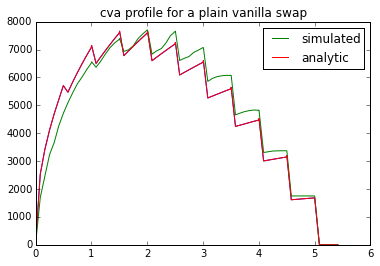

In [7]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from n09_cva_swap import EPE_Swaption

plt.title("cva profile for a plain vanilla swap")
plt.plot(sim_times,EPE, label='simulated')
plt.plot(sim_times,EPE_Swaption,color='red', label='analytic')
plt.legend()
plt.show()